<a href="https://colab.research.google.com/github/wangjalen7/project_chd/blob/main/CHD_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jalen's Model

## Data Cleaning

In [43]:
import pandas as pd

train_data_path = './data/fhs_train_jalen.csv'
test_data_path = './data/fhs_test_jalen.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

train_data.head(), train_data.describe(), train_data.info(), test_data.head(), test_data.describe(), test_data.info()


FileNotFoundError: [Errno 2] No such file or directory: './data/fhs_train_jalen.csv'

In [ ]:
# Drop first unnamed column from both datasets
train_data.drop(columns='Unnamed: 0', inplace=True)
test_data.drop(columns='Unnamed: 0', inplace=True)

# Impute missing values
# For continuous variables, used median to avoid the effect of outliers.
# For categorical variables, used mode.
categorical_cols = ['education', 'BPMeds']
continuous_cols = ['cigsPerDay', 'totChol', 'BMI', 'glucose']

# Impute training data
for col in categorical_cols:
    mode_value = train_data[col].mode()[0]
    train_data[col].fillna(mode_value, inplace=True)

for col in continuous_cols:
    median_value = train_data[col].median()
    train_data[col].fillna(median_value, inplace=True)

# Impute testing data the same way to keep consistent
for col in categorical_cols:
    mode_value = test_data[col].mode()[0]
    test_data[col].fillna(mode_value, inplace=True)

for col in continuous_cols:
    median_value = test_data[col].median()
    test_data[col].fillna(median_value, inplace=True)

train_missing_after = train_data.isnull().sum().sum()
test_missing_after = test_data.isnull().sum().sum()

train_missing_after, test_missing_after


(0, 1)

In [ ]:
# Impute the remaining missing value in the testing data
test_data['heartRate'].fillna(test_data['heartRate'].median(), inplace=True)

test_missing_final = test_data.isnull().sum().sum()

test_missing_final


0

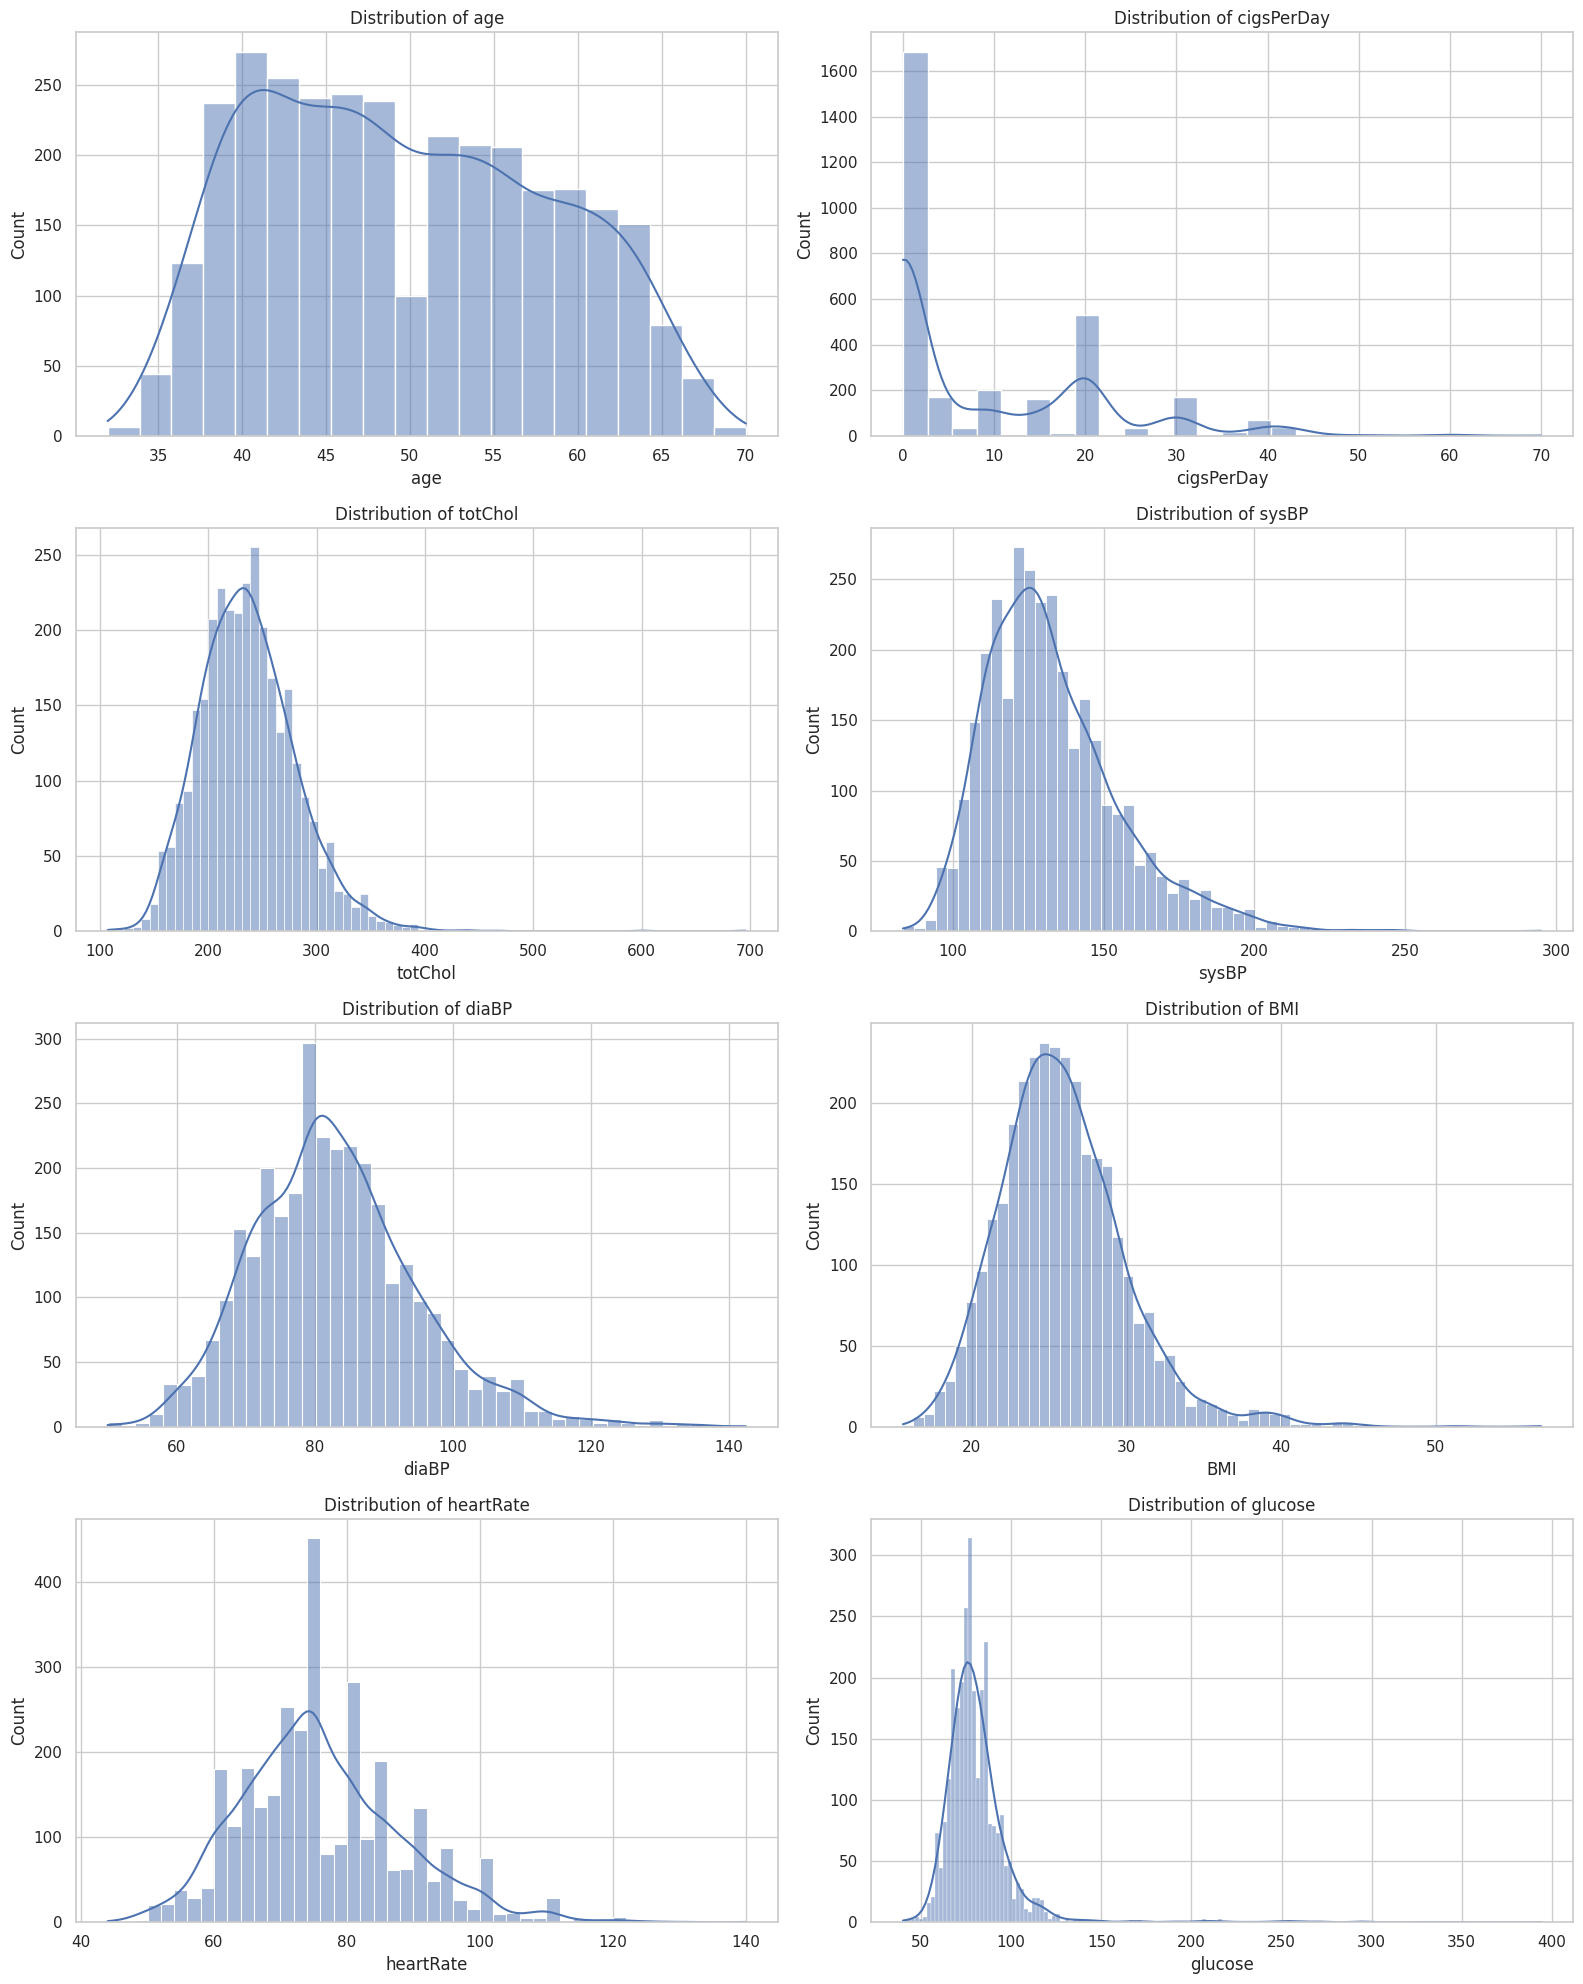

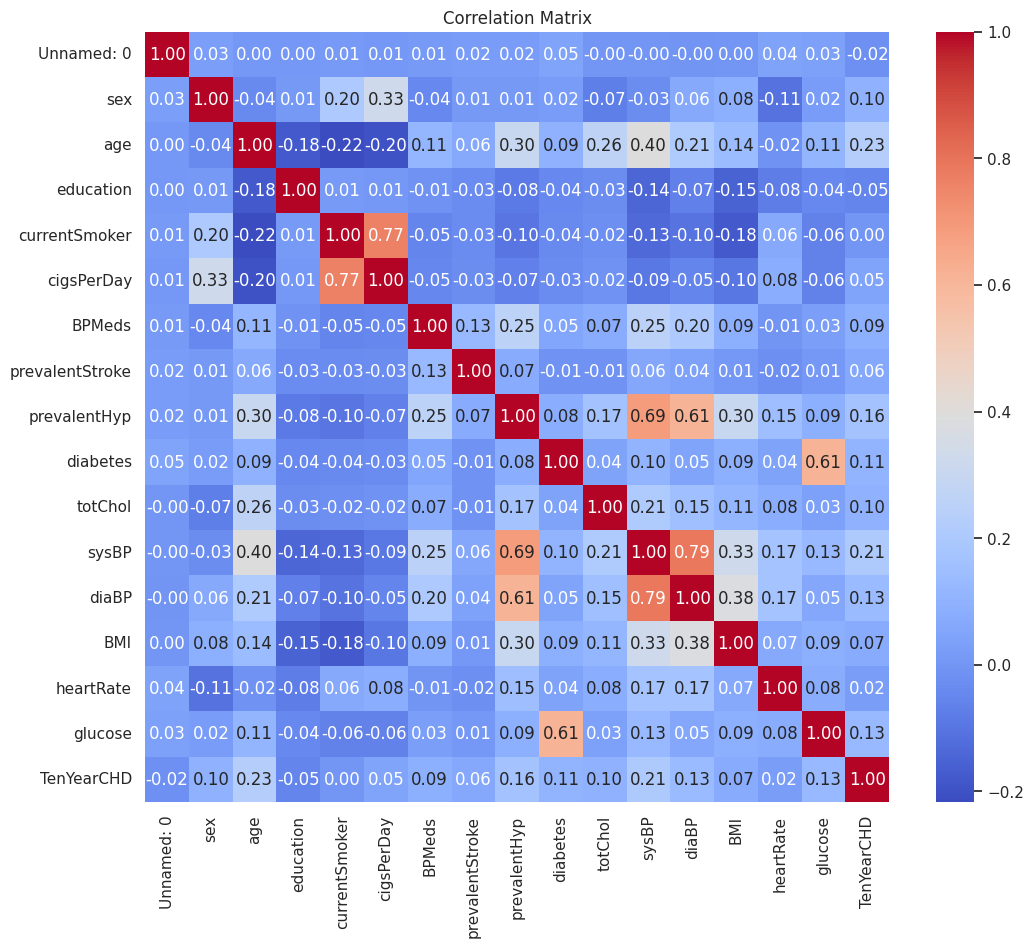

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
cont_columns = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
for i, col in enumerate(cont_columns):
    sns.histplot(train_data[col], kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Distribution of {col}')

fig.tight_layout()
plt.show()

corr_matrix = train_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


## K-Nearest Neigbors Model

In [37]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, r2_score

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Extract features and target variable from the training dataset
X = train_data.drop('TenYearCHD', axis=1)
y = train_data['TenYearCHD']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Grid search to find the optimal k using cross-validation
param_grid_knn = {'n_neighbors': list(range(1, 31))}
knn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='roc_auc', return_train_score=True)
knn_grid_search.fit(X_train, y_train)

# Best parameters and the corresponding score
optimal_k = knn_grid_search.best_params_['n_neighbors']
best_score = knn_grid_search.best_score_

optimal_k, best_score


(30, 0.6735462826105305)

In [ ]:
# Setup KNN with the optimal number of neighbors
optimal_knn_model = KNeighborsClassifier(n_neighbors=optimal_k)

# Train the model on the entire scaled training data
optimal_knn_model.fit(X_scaled, y)

# Prepare test data (scaling)
X_test = test_data.drop('TenYearCHD', axis=1)
y_test = test_data['TenYearCHD']
X_test_scaled = scaler.transform(X_test)  # Use the same scaler as for training data

# Predict probabilities on the test set
y_test_pred_proba_knn = optimal_knn_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC AUC and R² scores for the KNN model on the test data
roc_auc_test_knn = roc_auc_score(y_test, y_test_pred_proba_knn)
r2_test_knn = r2_score(y_test, y_test_pred_proba_knn)

roc_auc_test_knn, r2_test_knn


(0.6684688688095591, 0.044475637158202574)

# Decision Tree Approach (Tyler)

In [60]:
# path of the data
train_data_path = "./data/fhs_train.csv"
test_data_path = "./data/fhs_test.csv"

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

train_data.head()

,Unnamed: 0,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1267,1,58,1.0,0,0.0,0.0,0,0,0,220.0,143.0,104.0,29.85,75,87.0,1
1,1209,0,40,1.0,1,15.0,0.0,0,0,0,199.0,122.0,82.0,22.16,85,77.0,0
2,2050,0,52,1.0,0,0.0,0.0,0,0,0,275.0,112.0,71.0,25.68,80,NaN,0
3,1183,1,38,2.0,1,43.0,0.0,0,1,0,170.0,130.0,94.0,23.90,110,75.0,0
4,3225,0,43,1.0,0,0.0,0.0,0,0,0,202.0,124.0,92.0,21.26,75,74.0,0


In [61]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3180 entries, 0 to 3179
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       3180 non-null   int64  
 1   sex              3180 non-null   int64  
 2   age              3180 non-null   int64  
 3   education        3095 non-null   float64
 4   currentSmoker    3180 non-null   int64  
 5   cigsPerDay       3156 non-null   float64
 6   BPMeds           3143 non-null   float64
 7   prevalentStroke  3180 non-null   int64  
 8   prevalentHyp     3180 non-null   int64  
 9   diabetes         3180 non-null   int64  
 10  totChol          3141 non-null   float64
 11  sysBP            3180 non-null   float64
 12  diaBP            3180 non-null   float64
 13  BMI              3165 non-null   float64
 14  heartRate        3180 non-null   int64  
 15  glucose          2895 non-null   float64
 16  TenYearCHD       3180 non-null   int64  
dtypes: float64(8),

In [62]:
train_data.describe()

,Unnamed: 0,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3180.000000,3180.000000,3180.000000,3095.000000,3180.000000,3156.000000,3143.000000,3180.000000,3180.000000,3180.000000,3141.000000,3180.000000,3180.000000,3165.000000,3180.000000,2895.000000,3180.000000
mean,2129.740881,0.433019,49.633962,1.957027,0.490881,8.970532,0.029590,0.006604,0.321069,0.026101,236.600764,132.784748,83.117767,25.888117,75.942138,81.833506,0.153145
std,1231.779357,0.495571,8.557596,1.011135,0.499995,12.013704,0.169479,0.081008,0.466961,0.159460,44.847411,22.433267,12.009212,4.130475,12.050504,23.625357,0.360184
min,1.000000,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,50.000000,15.540000,44.000000,40.000000,0.000000
25%,1062.750000,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,205.000000,117.000000,75.000000,23.100000,68.000000,71.000000,0.000000
50%,2137.500000,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,233.000000,129.000000,82.000000,25.490000,75.000000,78.000000,0.000000
75%,3209.250000,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,262.000000,144.125000,90.000000,28.140000,83.000000,87.000000,0.000000
max,4240.000000,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,140.000000,394.000000,1.000000


## **EDA**

In [63]:
# get the shapes of the dataset
print("Shape of training data:", train_data.shape)
print("Shape of Test Data:", test_data.shape)

Shape of training data: (3180, 17)
Shape of Test Data: (1060, 17)


In [64]:
# correlation matrix
corr_matrix = train_data.corr()
print(corr_matrix['TenYearCHD'].sort_values(ascending = False))

TenYearCHD         1.000000
age                0.225568
sysBP              0.205898
prevalentHyp       0.163910
diaBP              0.133094
glucose            0.126485
diabetes           0.105644
totChol            0.099704
sex                0.097138
BPMeds             0.088135
BMI                0.072830
prevalentStroke    0.062357
cigsPerDay         0.047712
heartRate          0.023205
currentSmoker      0.001644
Unnamed: 0        -0.019496
education         -0.052668
Name: TenYearCHD, dtype: float64


The first step was creating a correlation matrix to see which values seem to correlate the most with `TenYearCHD` variable. The correlation matrix seems to indicate that `age`, `sysBP`, `prevalentHyp`, `diaBP`, `glucose`, and `diabetes` have the highest correlations above `0.09`.

In [65]:
# provide two lists; one for features of interest and the other for target
variables_of_interest = ["age", "sysBP", "prevalentHyp", "diaBP", "glucose", "diabetes"]
target_variable = ["TenYearCHD"]

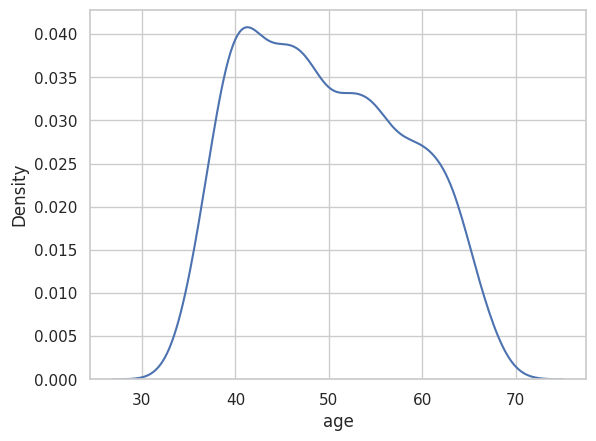

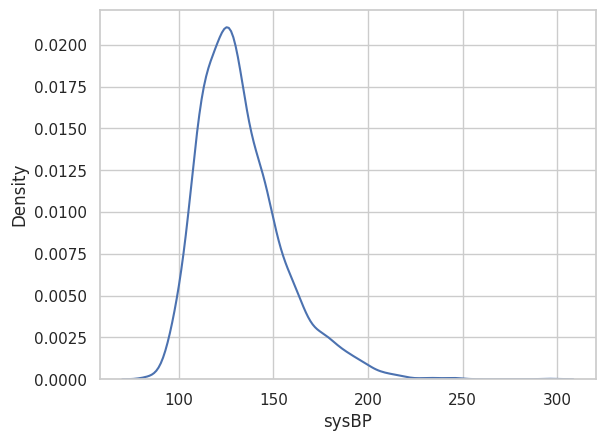

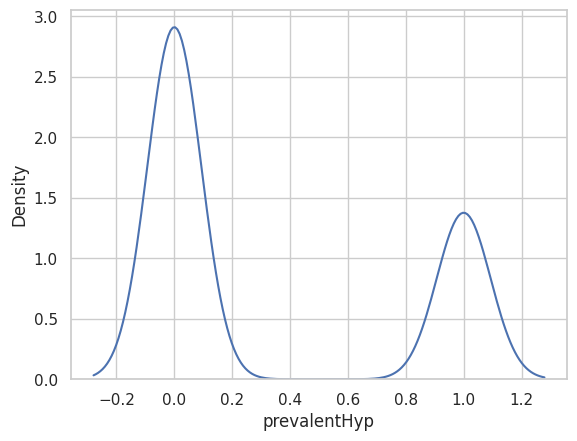

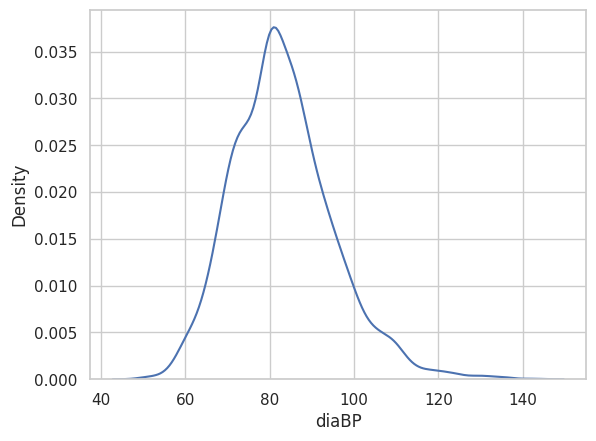

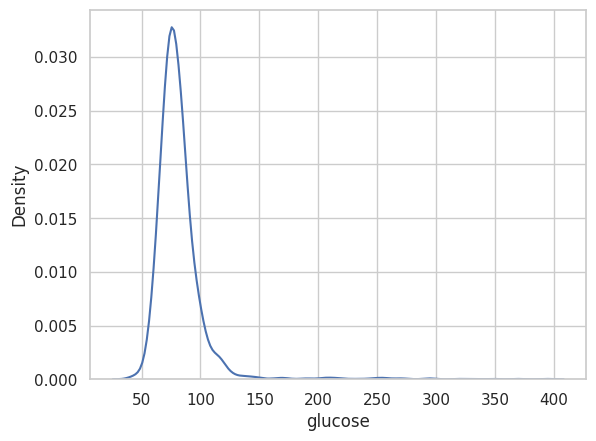

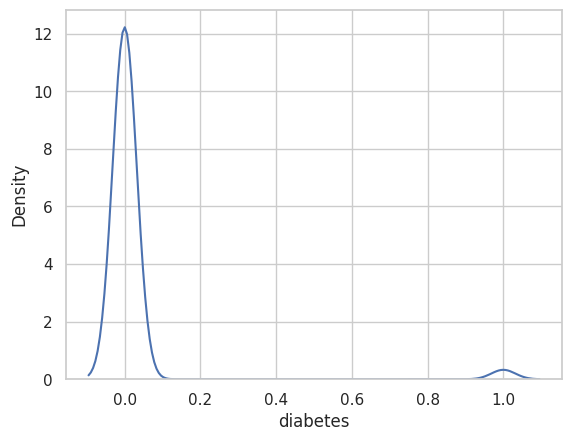

In [66]:
for feature in variables_of_interest:
  sns.kdeplot(data = train_data, x = feature)
  plt.show()

## **Data Preprocessing**

In [67]:
# setup datasets
X_train = train_data.loc[:, variables_of_interest]
y_train = train_data.loc[:, target_variable]
X_test = test_data.loc[:, variables_of_interest]
y_test = test_data.loc[:, target_variable]

In [68]:
print(train_data["age"].unique(), "\n")
print(train_data["age"].value_counts(), "\n")

[58 40 52 38 43 56 54 47 61 59 64 45 51 63 57 48 46 60 39 53 49 50 44 68
 41 65 55 34 35 37 66 42 62 67 36 33 32 70 69] 

age
48    139
42    139
40    138
46    137
41    136
39    125
45    125
43    116
44    116
55    113
52    113
38    112
47    107
53    104
54    103
51    101
50    100
49    100
56     93
58     91
60     90
61     87
59     86
63     85
57     84
62     75
64     66
37     63
36     60
65     50
67     31
35     30
66     29
34     14
68     10
33      5
69      4
70      2
32      1
Name: count, dtype: int64 



In [69]:
print(test_data["age"].unique(), "\n")

[58 51 44 40 53 41 50 42 45 52 57 46 38 47 48 56 66 68 59 54 49 39 61 62
 67 43 64 37 34 35 55 36 63 65 60 69] 



In [70]:
print(train_data["sysBP"].unique(), "\n")

[143.  122.  112.  130.  124.  126.  171.5 138.  114.  134.5 100.5 135.
 117.5 133.  142.  120.  131.  113.  110.  131.5 101.   96.  102.5 127.5
 116.  162.  146.  115.  127.  140.5 132.  112.5 145.  148.  141.  150.
  99.  195.  107.5 109.  116.5 165.  149.  183.   93.5 140.  124.5 193.
 122.5 119.  102.  134.  132.5 128.  141.5 111.  106.  129.  178.  125.
 136.  137.5 151.5 153.  125.5 188.  174.  142.5 157.  111.5 113.5 192.5
 105.5 146.5 160.  147.  158.  214.  151.  152.  155.5 155.  144.  117.
 121.  105.  115.5 160.5 137.  126.5 118.  190.  184.5  94.  180.  147.5
 108.  199.  130.5 119.5  95.  118.5 175.  154.  152.5 197.  103.  150.5
 139.  100.  133.5 143.5 173.  107.  123.  220.  168.5 187.  106.5 205.
 164.5  98.  108.5 172.5 185.  163.  159.  120.5 144.5 202.5  92.  244.
 153.5 168.  205.5 114.5 136.5 167.  110.5 166.5 109.5 170.5 163.5 206.
 176.  139.5 194.  121.5 162.5 104.  158.5 154.5 156.  145.5  97.  196.
 171.  164.  161.5 184.  135.5  97.5 215.  166.  156.5 157.5

In [71]:
print(test_data["sysBP"].unique(), "\n")

[126.  135.  147.5 138.5 110.  140.5 129.5 102.  139.  130.  126.5 107.5
 157.  144.  146.5 141.5 115.5 105.  132.  124.  128.  127.  147.  120.
 140.  146.  106.  109.  112.5 118.  122.  158.  122.5 125.  152.   97.
 114.  121.  111.  155.  171.  141.  145.  129.  119.  127.5 123.  117.
 152.5 131.5 134.  117.5 138.  101.  116.5 167.5 142.  154.  108.  100.
 160.  131.  159.  111.5 133.  158.5 112.  115.  137.5 153.  207.  116.
 182.5 195.  136.  151.  210.  125.5 150.  172.5 107.  156.  137.  165.
 174.  160.5 149.  168.5 130.5 164.   95.5 148.  143.5 113.5  97.5 118.5
 102.5 120.5 108.5 119.5 170.  166.  168.  113.  174.5 204.   92.5  98.
 124.5 103.  202.   99.5 149.5 133.5 132.5 180.  175.  181.  142.5 128.5
 167.  183.  215.  104.  150.5  94.  121.5 173.  162.5 162.  136.5 196.
 103.5 176.  143.  169.  156.5 114.5 164.5 135.5 186.5 191.  110.5 197.
 200.  134.5 206.  189.   96.  123.5 187.  163.5 192.5  95.  161.   99.
 100.5 139.5 177.  213.  176.5 105.5 184.  154.5 207.5 163.  

In [72]:
print(train_data["prevalentHyp"].unique(), "\n")
print(train_data["prevalentHyp"].value_counts(), "\n")

[0 1] 

prevalentHyp
0    2159
1    1021
Name: count, dtype: int64 



In [73]:
print(test_data["prevalentHyp"].unique(), "\n")
print(test_data["prevalentHyp"].value_counts(), "\n")

[0 1] 

prevalentHyp
0    764
1    296
Name: count, dtype: int64 



In [74]:
print(train_data["diaBP"].unique(), "\n")
print(train_data["diaBP"].value_counts(), "\n")

[104.   82.   71.   94.   92.   83.  105.5  96.   76.   87.   66.   80.
  82.5  86.   90.   85.   68.   77.5  68.5  72.   72.5  81.5  91.   84.
  78.   75.   66.5  76.5  95.   77.   93.   70.   62.  100.  110.   73.
  81.   62.5 108.   58.   92.5  79.   69.   89.5  85.5 103.   61.   88.
 106.   71.5  63.5  97.  104.5  98.   74.  113.   60.   57.5  73.5  86.5
  65.  109.  102.   99.5  84.5  80.5  70.5  78.5  90.5  74.5  67.5  67.
  88.5  89.   99.   97.5  50.  118.   63.   79.5  98.5 128.  107.5 130.
  87.5 105.  101.   91.5 124.  123.  107.   94.5 106.5 100.5 111.   75.5
  64.  103.5 115.  121.   95.5  57.   64.5 119.  112.  102.5  93.5  83.5
 129.   69.5 120.   59.  109.5  55.   96.5 112.5 133.   54.  115.5  65.5
 114.  125.   52.  110.5 135.   59.5 116.  108.5  56.  101.5 136.   51.
 124.5 117.   60.5 142.5 116.5 117.5 122.5] 

diaBP
80.0     198
82.0     106
84.0     102
85.0     102
81.0      98
        ... 
115.5      1
135.0      1
110.5      1
129.0      1
122.5      1
Name: cou

In [75]:
print(train_data["glucose"].unique(), "\n")
print(train_data["glucose"].value_counts(), "\n")

[ 87.  77.  nan  75.  74. 104.  69.  90.  91.  81.  89.  86.  84.  73.
  95.  65. 103.  76.  85.  92.  72.  62.  93.  68.  67. 122. 102.  79.
  66.  83.  78.  64.  63.  58.  71. 115.  70.  96.  60.  82.  94.  88.
 167. 117. 215.  48. 108. 268. 100.  80.  99. 135.  97.  55. 274.  40.
 118.  47.  56. 112. 248. 107. 105.  61. 260. 170. 148. 120. 225.  98.
  59. 332. 110. 206. 129.  57. 114. 101. 113. 111. 127. 121.  45. 147.
  50. 244. 106. 394. 173. 116. 137. 145. 123.  44. 172.  54. 142. 348.
 119. 320.  53. 136. 210.  43. 144. 292. 125. 294. 130. 131. 255. 160.
  52. 207. 297. 216. 166. 109. 126. 235. 140. 270. 250. 193. 256. 150.
 202. 254. 370. 191. 186.] 

glucose
75.0     147
77.0     126
73.0     119
80.0     117
70.0     113
        ... 
348.0      1
119.0      1
320.0      1
136.0      1
186.0      1
Name: count, Length: 130, dtype: int64 



In [76]:
print(train_data["diabetes"].unique(), "\n")
print(train_data["diabetes"].value_counts(), "\n")

[0 1] 

diabetes
0    3097
1      83
Name: count, dtype: int64 



In [83]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3180 entries, 0 to 3179
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           3180 non-null   int64  
 1   sysBP         3180 non-null   float64
 2   prevalentHyp  3180 non-null   int64  
 3   diaBP         3180 non-null   float64
 4   glucose       2895 non-null   float64
 5   diabetes      3180 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 149.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1060 non-null   int64  
 1   sysBP         1060 non-null   float64
 2   prevalentHyp  1060 non-null   int64  
 3   diaBP         1060 non-null   float64
 4   glucose       957 non-null    float64
 5   diabetes      1060 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 49.8 

Seems like only `glucose` has null values. Assuming that the samples are drawn from a similar body of samples, it may make sense to impute the mean for all `null` values.

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Create a pipeline
num_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
    ("imputer", SimpleImputer(strategy = "mean"))
])

In [79]:
X_train_tr = num_pipeline.fit_transform(X_train)
X_test_tr = num_pipeline.fit_transform(X_test)

In [80]:
print(y_train)

      TenYearCHD
0              1
1              0
2              0
3              0
4              0
...          ...
3175           0
3176           0
3177           1
3178           0
3179           0

[3180 rows x 1 columns]


We will try the decision tree approach to see what it yields.

[Text(0.4923624067164179, 0.9545454545454546, 'age <= -0.133\ngini = 0.259\nsamples = 3180\nvalue = [2693, 487]'),
 Text(0.21159825870646767, 0.8636363636363636, 'glucose <= 6.378\ngini = 0.146\nsamples = 1563\nvalue = [1439, 124]'),
 Text(0.16138059701492538, 0.7727272727272727, 'diaBP <= 0.552\ngini = 0.142\nsamples = 1558\nvalue = [1438, 120]'),
 Text(0.07587064676616916, 0.6818181818181818, 'sysBP <= -2.164\ngini = 0.121\nsamples = 1255\nvalue = [1174, 81]'),
 Text(0.0708955223880597, 0.5909090909090909, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.08084577114427861, 0.5909090909090909, 'sysBP <= 1.637\ngini = 0.119\nsamples = 1254\nvalue = [1174, 80]'),
 Text(0.07587064676616916, 0.5, 'age <= -1.068\ngini = 0.118\nsamples = 1253\nvalue = [1174, 79]'),
 Text(0.03731343283582089, 0.4090909090909091, 'glucose <= 1.679\ngini = 0.066\nsamples = 469\nvalue = [453, 16]'),
 Text(0.03233830845771144, 0.3181818181818182, 'diabetes <= 2.972\ngini = 0.062\nsamples = 468\nvalue = [453, 

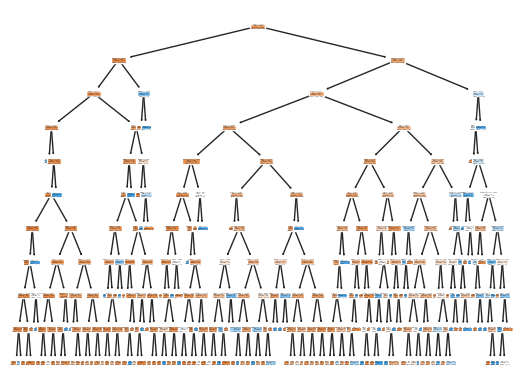

In [81]:
from sklearn import tree

# create a decision tree
dt = tree.DecisionTreeClassifier(max_depth = 10)
dt.fit(X_train_tr, y_train)
tree.plot_tree(dt, feature_names = X_train.columns.to_list(), filled = True)

In [96]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

# predict and check accuracy
y_hat_dt = dt.predict(X_test_tr)
acc_dt = accuracy_score(y_test, y_hat_dt) # calculate accuracy
r2_dt = dt.score(X_test_tr, y_test) # calculate r^2
roc_auc_dt = roc_auc_score(y_test, y_hat_dt) # area under curve
confusion_matrix = metrics.confusion_matrix(y_test, y_hat_dt)
print(confusion_matrix)

[[863  40]
 [136  21]]


In [94]:
print("Accuracy:", acc_dt, "\nR squared:", r2_dt, "\nArea Under the ROC curve:", roc_auc_dt)

Accuracy: 0.8339622641509434 
R squared: 0.8339622641509434 
Area Under the ROC curve: 0.5447305866503023


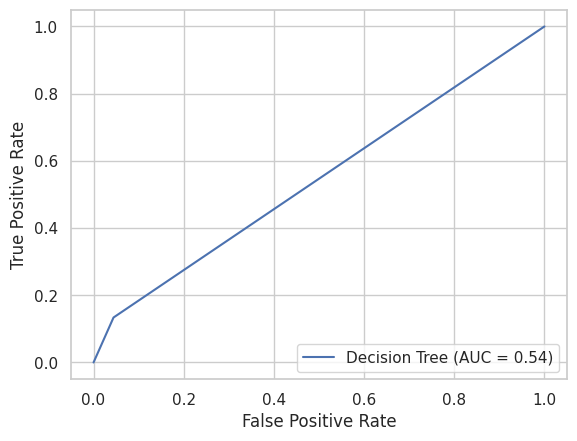

In [100]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_hat_dt)
roc_auc_dt = metrics.auc(fpr, tpr)

roc_curve = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc_dt, estimator_name = "Decision Tree")
roc_curve.plot()
plt.show()

The `Accuracy` and `R squared` seem both to be pretty good getting around $83$% correct. However, the `area under the curve` is around $50$% which is essentially guessing. Possibilities include using the incorrect metrics for this particular type of problem or a discrepancy in which the various metrics are calculated.